# Özel (Custom) Transformer

In [1]:
import pandas as pd
import seaborn as sns

👉 Bu veri setini kullanacağız:

In [2]:
data = pd.read_csv("https://d32aokrjazspmn.cloudfront.net/materials/custom_transformer_data.csv")
data.head()

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm,days_until_delivery
0,RJ,SP,1825,53,10,40,9
1,RJ,SP,700,65,18,28,9
2,RJ,SP,1825,53,10,40,11
3,RJ,SP,1825,53,10,40,12
4,RJ,SP,1825,53,10,40,14


- Veri setindeki her bir gözlem, bir ürünün bir `seller_state`’ten bir `customer_state`’e teslim edilmesini temsil eder.  
- Diğer sütunlar, her bir ürünün paketleme özelliklerini açıklar.

🎯 Hedef, sipariş ile teslimat arasındaki gün sayısıdır.

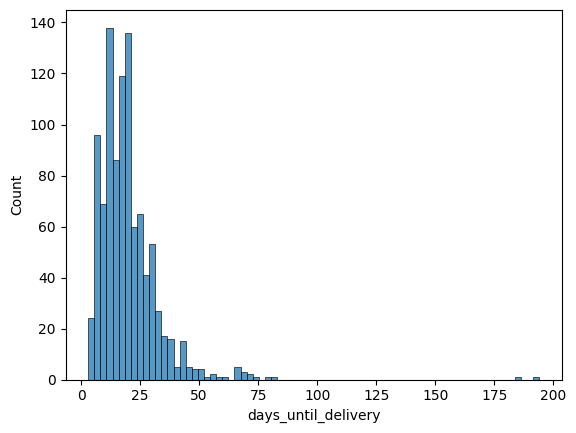

In [3]:
#  Hedefi kontrol et
sns.histplot(data.days_until_delivery);

## 1. Pipeline

👉 `pipe` adlı bir scikit-learn pipeline oluşturun:

- Boyut feature’larından (`dimensions`) bir `volume` feature’ı türetin
- Eğitim için orijinal ürün boyut feature’larını koruyun
- Tüm sayısal feature’ları ölçekleyin
- Kategorik feature’ları encode edin
- Varsayılan ayarlarla bir `Ridge` regresyon estimator’ı ekleyin

**Not:** Bu challenge için holdout yöntemi yok sayılacaktır; yani `train_test_split` kullanmanıza gerek yoktur!

In [4]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.linear_model import Ridge

# X / y
X = data.drop(columns="days_until_delivery")
y = data["days_until_delivery"]

# kolonlar
dimension_cols = ["product_length_cm", "product_height_cm", "product_width_cm"]
numeric_cols = ["product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm"]
categorical_cols = ["seller_state", "customer_state"]

# volume fonksiyonu (Pandas output uyumlu)
def compute_volume_df(X_in):
    X_arr = np.asarray(X_in)
    if X_arr.ndim == 1:
        X_arr = X_arr.reshape(-1, 1)
    vol = np.prod(X_arr, axis=1)
    return pd.DataFrame({"volume": vol})

volume_pipeline = Pipeline(steps=[
    ("volume", FunctionTransformer(compute_volume_df, validate=False)),
    ("scaler", MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numeric_cols),
        # KRİTİK: binary ise 2. kolonu drop et -> test bunu istiyor
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="if_binary"), categorical_cols),
        ("vol", volume_pipeline, dimension_cols),
    ],
    remainder="drop"
)

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", Ridge())
]).set_output(transform="pandas")

<details><summary><strong>İpuçları</strong></summary>

- Ön işlenmiş feature matrisinizi oluşturmanın birçok yolu vardır (`ColumnTransformer` ve/veya `FeatureUnion` kullanarak). 
    
- Dönüştürülmüş feature matrisiniz garip görünüyorsa, bunun nedeni `OneHotEncoder(sparse_output=True)` varsayılan davranışıyla matrisin "sparse" olarak saklanması olabilir. Bunu tekrar dense bir matrise çevirmek için `.todense()` kullanın.

- Varsayılan NumPy array çıktısı yerine sütun adlarıyla birlikte bir Pandas DataFrame çıktısı almak için, final pipeline’ınızda `.set_output(transform='pandas')` kullanın. (Bunu her bir transformer üzerinde tek tek ayarlamanıza gerek yoktur. Pipeline üzerinde ayarlarsanız, bunu alt aşamalara da aktarır.)

</details>

<br>

<details><summary><strong>Daha fazla ipucu: adım adım yönlendirme</strong> (yalnızca takılırsanız açın)</summary>

Pipeline’ı oluşturmanın en kolay yolu budur.

1. Uzunluk, genişlik ve yükseklik verildiğinde hacmi hesaplayan bir python `function` oluşturun.
2. Aşağıdakilerden oluşan bir hacim hesaplayıcı pipeline oluşturun:
   1. Python `function`’ınızı kullanan bir `FunctionTransformer`.
   1. Ardından bir scaler
3. `ColumnTransformer` kullanarak tam bir preprocessor oluşturun:
   - Orijinal sayısal feature’lar için bir scaler.
   - Kategorik feature’lar için bir encoder.
   - Uzunluk, genişlik ve yükseklik feature’ları için hacim hesaplayıcı pipeline’ınız.
4. Son olarak, tam preprocessor’ınızı ve ardından `Ridge` modelini içeren bir pipeline oluşturun.

</details>

#### 🧪  pipe'ını test et

In [5]:
from nbresult import ChallengeResult

pipe_test = pipe

# Çökmediğini kontrol edin
assert pipe_test.fit(X, y)

result = ChallengeResult(
    'pipe',
    shape = pipe_test[:-1].fit_transform(X).shape
)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/gizemtotkanli/.pyenv/versions/workintech_current/bin/python
cachedir: .pytest_cache
rootdir: /Users/gizemtotkanli/code/totkanligizem/S17D1-S-Data-Custom-Transformer/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_pipe.py::TestPipe::test_pipe_not_crashing PASSED                    [100%]

============================== 1 passed in 0.35s ===============================


💯 You can commit your code:

git add tests/pipe.pickle

git commit -m 'Completed pipe step'

git push origin master



## 2. Train ve Predict

👇 `data`’nın tüm eğitim veri setiniz olduğunu varsayalım.

- Bu veri seti üzerinde pipeline’ınızı `cross_validate` edin (❗️düşük $R^2$ skorları beklenmektedir)
- Şimdi de yeni bir sipariş aldığınızı varsayın: `new_data`  
  Teslimat süresini tahmin edin ve sonucu `prediction` adlı değişkende saklayın

In [6]:
new_data = pd.read_csv("https://d32aokrjazspmn.cloudfront.net/materials/custom_transformer_new_order.csv")
new_data

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,RJ,SP,1825,53,10,40


In [7]:
from sklearn.model_selection import cross_validate
import numpy as np

# CV için pandas output'u kapat (index mismatch hatasını engeller)
pipe_cv = pipe.set_output(transform="default")

cv_results = cross_validate(
    pipe_cv,
    X, y,
    cv=5,
    scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
    error_score="raise"  # istersen "np.nan" da kalabilir; raise debug için iyi
)

print("CV R2 mean:", cv_results["test_r2"].mean())
print("CV MAE mean:", -cv_results["test_neg_mean_absolute_error"].mean())
print("CV RMSE mean:", -cv_results["test_neg_root_mean_squared_error"].mean())

# Tahmin (final training + predict)
prediction = float(pipe_cv.fit(X, y).predict(new_data)[0])
prediction

CV R2 mean: 0.1260533999833001
CV MAE mean: 7.503465365779832
CV RMSE mean: 12.1688396286231


/Users/gizemtotkanli/.pyenv/versions/workintech_current/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gizemtotkanli/.pyenv/versions/workintech_current/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gizemtotkanli/.pyenv/versions/workintech_current/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


20.659945181496745

In [8]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'prediction',
    prediction = prediction
)

result.write()
print(result.check())



============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/gizemtotkanli/.pyenv/versions/workintech_current/bin/python
cachedir: .pytest_cache
rootdir: /Users/gizemtotkanli/code/totkanligizem/S17D1-S-Data-Custom-Transformer/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_prediction.py::TestPrediction::test_prediction PASSED               [100%]

============================== 1 passed in 0.29s ===============================


💯 You can commit your code:

git add tests/prediction.pickle

git commit -m 'Completed prediction step'

git push origin master



🏁 Tebrikler. Not defterinizi eklemeyi, kaydetmeyi ve göndermeyi unutmayın.